In [1]:
import sys
import os
import torch
import yaml

from easydict import EasyDict as edict
from pytorch_transformers.tokenization_bert import BertTokenizer
from vilbert.datasets import ConceptCapLoaderTrain, ConceptCapLoaderVal
from vilbert.vilbert import VILBertForVLTasks, BertConfig, BertForMultiModalPreTraining
from vilbert.task_utils import LoadDatasetEval

import numpy as np
import matplotlib.pyplot as plt
import PIL

from PIL import Image
import cv2
import argparse
import glob
from types import SimpleNamespace
import pdb

%matplotlib inline  

07/13/2020 11:24:18 - INFO - vilbert.vilbert -   Better speed can be achieved with apex installed from https://www.github.com/nvidia/apex .


In [2]:
import torch
import torch.nn as nn
import torchvision.models as models
import torchvision.transforms as transforms
from torch.autograd import Variable
from PIL import Image
import config
import cv2
import matplotlib.pyplot as plt
import numpy as np

from faster_rcnn import feature_extractor as f_extractor

In [3]:
def tokenize_batch(batch):
    return [tokenizer.convert_tokens_to_ids(sent) for sent in batch]

def untokenize_batch(batch):
    return [tokenizer.convert_ids_to_tokens(sent) for sent in batch]

def detokenize(sent):
    """ Roughly detokenizes (mainly undoes wordpiece) """
    new_sent = []
    for i, tok in enumerate(sent):
        if tok.startswith("##"):
            new_sent[len(new_sent) - 1] = new_sent[len(new_sent) - 1] + tok[2:]
        else:
            new_sent.append(tok)
    return new_sent

def printer(sent, should_detokenize=True):
    if should_detokenize:
        sent = detokenize(sent)[1:-1]
    print(" ".join(sent))

def bert_tokenize( text):
    text = '[CLS]' + text + '[SEP]'
    tokenized_text = tokenizer.tokenize(text)
    print("tokenized text ",tokenized_text)
    indexed_tokens = tokenizer.convert_tokens_to_ids(tokenized_text)
    return indexed_tokens
    
# write arbitary string for given sentense. 
import pickle as cPickle

In [4]:
def prediction(question, features, spatials, segment_ids, input_mask, image_mask, co_attention_mask, task_tokens, ):

    vil_prediction, vil_prediction_gqa, vil_logit, vil_binary_prediction, vil_tri_prediction, vision_prediction, vision_logit, linguisic_prediction, linguisic_logit, attn_data_list, sequence_output_t,sequence_output_v,pooled_output_t,pooled_output_v = model(
        question, features, spatials, segment_ids, input_mask, image_mask, co_attention_mask, task_tokens, output_all_attention_masks=True
    )
    print(sequence_output_t.shape)
    print(sequence_output_v.shape)
    print(pooled_output_t.shape)
    print(pooled_output_v.shape)
    height, width = img.shape[0], img.shape[1]

    logits = torch.max(vil_prediction, 1)[1].data  # argmax
    # Load VQA label to answers:
    label2ans_path = os.path.join('save', "VQA" ,"cache", "trainval_label2ans.pkl")
    vqa_label2ans = cPickle.load(open(label2ans_path, "rb"))
    answer = vqa_label2ans[logits[0].item()]
    print("VQA: " + answer)

    # Load GQA label to answers:
    label2ans_path = os.path.join('save', "gqa" ,"cache", "trainval_label2ans.pkl")

    logtis_gqa = torch.max(vil_prediction_gqa, 1)[1].data
    gqa_label2ans = cPickle.load(open(label2ans_path, "rb"))
    answer = gqa_label2ans[logtis_gqa[0].item()]
    print("GQA: " + answer)

    # vil_binary_prediction NLVR2, 0: False 1: True Task 12
    logtis_binary = torch.max(vil_binary_prediction, 1)[1].data
    print("NLVR: " + str(logtis_binary.item()))

    # vil_entaliment:  
    label_map = {0:"contradiction", 1:"neutral", 2:"entailment"}
    logtis_tri = torch.max(vil_tri_prediction, 1)[1].data
    print("Entaliment: " + str(label_map[logtis_tri.item()]))

    # vil_logit: 
    logits_vil = vil_logit[0].item()
    print("ViL_logit: %f" %logits_vil)

    # grounding: 
    logits_vision = torch.max(vision_logit, 1)[1].data
    grounding_val, grounding_idx = torch.sort(vision_logit.view(-1), 0, True)

    examples_per_row = 5
    ncols = examples_per_row 
    nrows = 1
    figsize = [12, ncols*20]     # figure size, inches
    fig, ax = plt.subplots(nrows=nrows, ncols=ncols, figsize=figsize)

    for i, axi in enumerate(ax.flat):
        idx = grounding_idx[i]
        val = grounding_val[i]
        box = spatials[0][idx][:4].tolist()
        y1 = int(box[1] * height)
        y2 = int(box[3] * height)
        x1 = int(box[0] * width)
        x2 = int(box[2] * width)
        patch = img[y1:y2,x1:x2]
        axi.imshow(patch)
        axi.axis('off')
        axi.set_title(str(i) + ": " + str(val.item()))

    plt.axis('off')
    plt.tight_layout(True)
    plt.show()  

In [5]:
from copy import deepcopy
def mask_token_language_modelling(token):
    
    modified_token = deepcopy(token)
    
    type_modification = np.random.choice(np.array(["MASK", "random", "unaltered"]), p=[0.8, 0.1,0.1])
    length_token = len(modified_token) - 2
    num_masked_tokens = int(0.15*length_token)
    
    if num_masked_tokens<1:
        num_masked_tokens=1
        
    if type_modification=="MASK":
        for i in range(num_masked_tokens):
            indx = np.random.randint(length_token)
            modified_token[indx+1] = tokenizer.encode('MASK')[0]
            
    elif type_modification=="random":
        for i in range(num_masked_tokens):
            indx = np.random.randint(length_token)
            modified_token[indx+1] = np.random.randint(1024) #size of vacbulary
    else:
        pass
        
    return token, modified_token
        
    

In [6]:
def custom_prediction(query, task, features, infos):

    print("Query: ", query)
    query = '[CLS]' + query + '[SEP]'
    tokens = tokenizer.encode(query)
    print("Encoded tokens: ", tokens)
    #tokens= 
    #tokens = tokenizer.add_special_tokens_single_sentence(tokens)
    print("checking mask_token_language_modelling...\n")
    token,masked_tokens = mask_token_language_modelling(tokens)
    print(masked_tokens)

    segment_ids = [0] * len(tokens)
    input_mask = [1] * len(tokens)
    
    print("segments id: ", segment_ids)
    print("input mask: ", input_mask)

    max_length = 37
    if len(tokens) < max_length:
        # Note here we pad in front of the sentence /// SOULDN'T BE AFTER?
        padding = [0] * (max_length - len(tokens))
        tokens = tokens + padding
        input_mask += padding
        segment_ids += padding
        
    print("segments id: ", segment_ids)
    print("input mask: ", input_mask)
    
    text = torch.from_numpy(np.array(tokens)).cuda().unsqueeze(0)
    input_mask = torch.from_numpy(np.array(input_mask)).cuda().unsqueeze(0)
    segment_ids = torch.from_numpy(np.array(segment_ids)).cuda().unsqueeze(0)
    task = torch.from_numpy(np.array(task)).cuda().unsqueeze(0)
    print("text: ", text)
    print("input mask:", input_mask)
    print("segments id: ", segment_ids)
    print("taks: ", task)
         #print())
    num_image = len(infos)

    feature_list = []
    image_location_list = []
    image_mask_list = []
    for i in range(num_image):
        image_w = infos[i]['image_width']
        image_h = infos[i]['image_height']
        feature = features[i]
        num_boxes = feature.shape[0]

        g_feat = torch.sum(feature, dim=0) / num_boxes # Mean of features of all the selected regions
        num_boxes = num_boxes + 1
        feature = torch.cat([g_feat.view(1,-1), feature], dim=0)
        boxes = infos[i]['bbox']
        image_location = np.zeros((boxes.shape[0], 5), dtype=np.float32)
        image_location[:,:4] = boxes
        image_location[:,4] = (image_location[:,3] - image_location[:,1]) * (image_location[:,2] - image_location[:,0]) / (float(image_w) * float(image_h))
        image_location[:,0] = image_location[:,0] / float(image_w)
        image_location[:,1] = image_location[:,1] / float(image_h)
        image_location[:,2] = image_location[:,2] / float(image_w)
        image_location[:,3] = image_location[:,3] / float(image_h)
        g_location = np.array([0,0,1,1,1])
        image_location = np.concatenate([np.expand_dims(g_location, axis=0), image_location], axis=0)
        image_mask = [1] * (int(num_boxes))

        feature_list.append(feature)
        image_location_list.append(torch.tensor(image_location))
        image_mask_list.append(torch.tensor(image_mask))

    features = torch.stack(feature_list, dim=0).float().cuda()
    spatials = torch.stack(image_location_list, dim=0).float().cuda()
    image_mask = torch.stack(image_mask_list, dim=0).byte().cuda()
    co_attention_mask = torch.zeros((num_image, num_boxes, max_length)).cuda()

    prediction(text, features, spatials, segment_ids, input_mask, image_mask, co_attention_mask, task)

In [11]:

# =============================
# ViLBERT part
# =============================

args = SimpleNamespace(from_pretrained= "save/multitask_model/multi_task_model.bin",
                       bert_model="bert-base-uncased",
                       config_file="config/bert_base_6layer_6conect.json",
                       max_seq_length=101,
                       train_batch_size=1,
                       do_lower_case=True,
                       predict_feature=False,
                       seed=42,
                       num_workers=0,
                       baseline=False, #True does not work
                       img_weight=1,
                       distributed=False,
                       objective=1,
                       visual_target=0,
                       dynamic_attention=False,
                       task_specific_tokens=True,
                       tasks='1',
                       save_name='',
                       in_memory=False,
                       batch_size=1,
                       local_rank=-1,
                       split='mteval',
                       clean_train_sets=True
                      )

config = BertConfig.from_json_file(args.config_file)
with open('./vilbert_tasks.yml', 'r') as f:
    task_cfg = edict(yaml.safe_load(f))

task_names = []
for i, task_id in enumerate(args.tasks.split('-')):
    task = 'TASK' + task_id
    name = task_cfg[task]['name']
    task_names.append(name)

timeStamp = args.from_pretrained.split('/')[-1] + '-' + args.save_name
config = BertConfig.from_json_file(args.config_file)
default_gpu=True

if args.predict_feature:
    config.v_target_size = 2048
    config.predict_feature = True
else:
    config.v_target_size = 1601
    config.predict_feature = False

if args.task_specific_tokens:
    config.task_specific_tokens = True    

if args.dynamic_attention:
    config.dynamic_attention = True

config.visualization = True
num_labels = 3129

if args.baseline:
    
    model = BaseBertForVLTasks.from_pretrained(
        args.from_pretrained, config=config, num_labels=num_labels, default_gpu=default_gpu
        )
#     model = BertForMultiModalPreTraining.from_pretrained(
#         args.from_pretrained, config=config, num_labels=num_labels, default_gpu=default_gpu
#         )
else:
    model = VILBertForVLTasks.from_pretrained(
        args.from_pretrained, config=config, num_labels=num_labels, default_gpu=default_gpu
        )
model.eval()
cuda = torch.cuda.is_available()
print("GPU: ", torch.cuda.get_device_name(0))
if cuda: model = model.cuda(0)
    
tokenizer = BertTokenizer.from_pretrained(
    args.bert_model, do_lower_case=args.do_lower_case
)
print(model)
print(tokenizer)

07/13/2020 11:30:09 - INFO - vilbert.utils -   loading weights file save/multitask_model/multi_task_model.bin


GPU:  GeForce 940MX


07/13/2020 11:30:52 - INFO - pytorch_transformers.tokenization_utils -   loading file https://s3.amazonaws.com/models.huggingface.co/bert/bert-base-uncased-vocab.txt from cache at /home/mikel/.cache/torch/pytorch_transformers/26bc1ad6c0ac742e9b52263248f6d0f00068293b33709fae12320c0e35ccfbbb.542ce4285a40d23a559526243235df47c5f75c197f04f37d1a0c124c32c9a084


VILBertForVLTasks(
  (bert): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(30522, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): BertLayerNorm()
      (dropout): Dropout(p=0.1, inplace=False)
      (task_embeddings): Embedding(20, 768)
    )
    (v_embeddings): BertImageEmbeddings(
      (image_embeddings): Linear(in_features=2048, out_features=1024, bias=True)
      (image_location_embeddings): Linear(in_features=5, out_features=1024, bias=True)
      (LayerNorm): BertLayerNorm()
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0): BertLayer(
          (attention): BertAttention(
            (self): BertSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(i

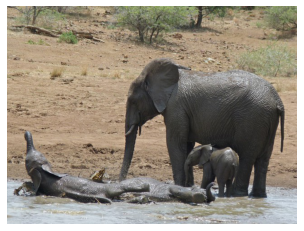

Query:  swimming elephant
Encoded tokens:  [101, 5742, 10777, 102]
checking mask_token_language_modelling...

[101, 5742, 7308, 102]
segments id:  [0, 0, 0, 0]
input mask:  [1, 1, 1, 1]
segments id:  [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
input mask:  [1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
text:  tensor([[ 101, 5742, 7308,  102,    0,    0,    0,    0,    0,    0,    0,    0,
            0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
            0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
            0]], device='cuda:0')
input mask: tensor([[1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
         0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]], device='cuda:0')
segments id:  tensor([[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
         0, 0, 0, 0, 0, 

FileNotFoundError: [Errno 2] No such file or directory: 'save/VQA/cache/trainval_label2ans.pkl'

In [42]:
# 1: VQA, 2: GenomeQA, 4: Visual7w, 7: Retrieval COCO, 8: Retrieval Flickr30k 
# 9: refcoco, 10: refcoco+ 11: refcocog, 12: NLVR2, 13: VisualEntailment, 15: GQA, 16: GuessWhat, 

## Faster RCNN 
frcnn_model = models.detection.fasterrcnn_resnet50_fpn(pretrained=True)
# read image 
#pic = "faster_rcnn/test2.png"
#pic1 = "faster_rcnn/test.png"
#image_paths = [pic, pic1]



image_path = ['demo/1.jpg']
features, infos = f_extractor.extract_features(image_path, frcnn_model)
#features, infos = feature_extractor.extract_features(image_path)

img = PIL.Image.open(image_path[0]).convert('RGB')
img = torch.tensor(np.array(img))

plt.axis('off')
plt.imshow(img)
plt.show()
    
query = "swimming elephant"
task = [9]
custom_prediction(query, task, features, infos)

In [8]:
frcnn_model

FasterRCNN(
  (transform): GeneralizedRCNNTransform()
  (backbone): BackboneWithFPN(
    (body): IntermediateLayerGetter(
      (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
      (bn1): FrozenBatchNorm2d()
      (relu): ReLU(inplace=True)
      (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
      (layer1): Sequential(
        (0): Bottleneck(
          (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (bn1): FrozenBatchNorm2d()
          (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
          (bn2): FrozenBatchNorm2d()
          (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (bn3): FrozenBatchNorm2d()
          (relu): ReLU(inplace=True)
          (downsample): Sequential(
            (0): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
            (1): FrozenBatchNorm2d()
          )
  

In [98]:
list(list(list(model.children())[0].modules())[1].modules())[0]

BertEmbeddings(
  (word_embeddings): Embedding(30522, 768, padding_idx=0)
  (position_embeddings): Embedding(512, 768)
  (token_type_embeddings): Embedding(2, 768)
  (LayerNorm): BertLayerNorm()
  (dropout): Dropout(p=0.1, inplace=False)
  (task_embeddings): Embedding(20, 768)
)

In [97]:
for idx, m in enumerate(model.children.named_modules()):
    print(idx, '->', m)

AttributeError: 'function' object has no attribute 'named_modules'

In [13]:
from torchvision.models.detection import faster_rcnn 

In [15]:
m = faster_rcnn


In [28]:
list(m.fasterrcnn_resnet50_fpn().modules())

Downloading: "https://download.pytorch.org/models/resnet50-19c8e357.pth" to /home/salem/.cache/torch/checkpoints/resnet50-19c8e357.pth


ImportError: IntProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html

In [26]:
dir(m)

['AnchorGenerator',
 'F',
 'FastRCNNPredictor',
 'FasterRCNN',
 'GeneralizedRCNN',
 'GeneralizedRCNNTransform',
 'MultiScaleRoIAlign',
 'OrderedDict',
 'RPNHead',
 'RegionProposalNetwork',
 'RoIHeads',
 'TwoMLPHead',
 '__all__',
 '__builtins__',
 '__cached__',
 '__doc__',
 '__file__',
 '__loader__',
 '__name__',
 '__package__',
 '__spec__',
 'fasterrcnn_resnet50_fpn',
 'load_state_dict_from_url',
 'misc_nn_ops',
 'model_urls',
 'nn',
 'resnet_fpn_backbone',
 'torch']